## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

# Initialize

### Import python packages and initialize gpus

In [19]:
from IPython import display
import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical
from absl import app, flags
if not sys.version_info[0]==3:
    sys.exit("Python 3 required")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        print(e)        
tfk.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

2 Physical GPUs 2 Logical GPUs


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
num devices = 2


### Set parameters

In [20]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

### Flatten MNIST data 28*28 to 784

In [21]:
(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()
##### from N*28*28 to N*784 #####
def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)
print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


### Sort it by labels(0-9)

In [22]:
sort_idx = np.argsort(trn_labels)
trn_labels = trn_labels[sort_idx]
trn_images = trn_images[sort_idx, :]
print(trn_labels.shape)
print(trn_images.shape)
_, class_count = np.unique(trn_labels, return_counts=True)
class_cumsum = np.cumsum(class_count)
print('class count: ', class_count)
print('class cumsum: ', class_cumsum)

(60000,)
(60000, 784)
class count:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
class cumsum:  [ 5923 12665 18623 24754 30596 36017 41935 48200 54051 60000]


### Bag MNIST data into instances

In [23]:
bag_idx = np.array([])
for kk in np.arange(NUM_CLASS):
    trim = (class_count[kk]//NUM_INSTANCES)*NUM_INSTANCES
    if kk == 0:
        bag_idx = np.hstack([bag_idx, np.arange(trim)])
    else:
        bag_idx = np.hstack([bag_idx, class_cumsum[kk-1]+np.arange(trim)])
bag_idx = np.ix_(bag_idx.astype('int'))
bagged_trn_labels = trn_labels[bag_idx].reshape((-1, NUM_INSTANCES))
bagged_trn_images = trn_images[bag_idx, :].reshape((-1, NUM_INSTANCES, 28*28))
print(bagged_trn_labels.shape)
print(bagged_trn_images.shape)

(2853, 21)
(2853, 21, 784)


### Creat dataset for distributed training

In [29]:
BUFFER_SIZE = bagged_trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
trn_dataset = tf.data.Dataset
                .from_tensor_slices(bagged_trn_images)
                .shuffle(BUFFER_SIZE)
                .batch(GLOBAL_BATCH_SIZE)
trn_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 21, 784), dtype=tf.float32, name=None)>

In [28]:
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)
trn_dist_dataset

2022-06-24 13:43:12.715317: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2853
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:57"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 21
        }
        dim {
          size: 784
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_FLOAT
        }
      }
  

# Define GVAE Model

### Layers

In [37]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mask_rate = mask_rate
        self.style_dim = style_dim
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",)
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",)
        
    def call(self, inputs):
        X = inputs 
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        common = self.enc_per_instance(inputs)
        z_mean = self.enc_mean(common)
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        z_mean = tfkl.Dropout(self.mask_rate)(z_mean)
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        super().__init__(name=name, **kwargs)
        self.content_dim = content_dim
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )  
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )
    def call(self, inputs):
        X = inputs
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        common = self.enc_per_instance(inputs)
        z_mean = self.enc_mean(common)
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)  
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)   
        return z_mean
    
class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, name='decoder', **kwargs):
        super().__init__(name=name, **kwargs)
        self.data_dim = data_dim     
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        return x_mean
    
class SYMAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mask_rate = mask_rate
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim

        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim)
        
    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])     
        # decode
        dec_mean = self.decoder(z)
        """ compute ELBO loss """
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        return se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))"""
        X = inputs
        ninstances = X.shape[1]  
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])  
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)
        return dec_mean
    
    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])  
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)
        return dec_mean

# Optimization

### Set optimization parameters

If you want to use the weights stored in './checkpoint',
set load_weights = True

In [71]:
with strategy.scope():
    load_weights = True
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.9
    initial_learning_rate = 2e-4
    ninstances = NUM_INSTANCES
    symae = SYMAE(data_dim, style_dim, content_dim, mask_rate)
    if load_weights == True:
        symae.load_weights('./checkpoint')
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)
    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()
    

### Set each training step

In [72]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        mse_per_ex, _ = symae(inputs, training=True)
        loss = tf.nn.compute_average_loss(mse_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
    trn_loss_metric(mse_per_ex)
    grads = tape.gradient(loss, symae.trainable_weights)
    opt.apply_gradients(zip(grads, symae.trainable_weights))
    return loss

@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 

# Train and Plot

Start of epoch 95
mean loss = 645.733
epoch running time = 0.76s
=== TRN ===


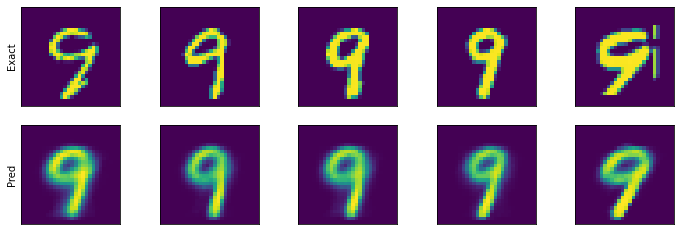

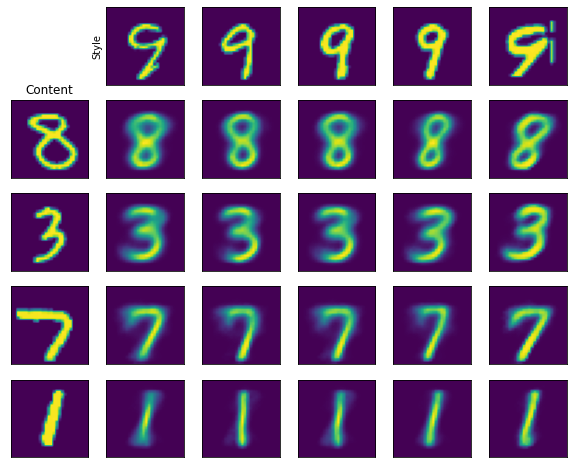

Start of epoch 96
mean loss = 647.171
epoch running time = 0.65s
Start of epoch 97
mean loss = 647.369
epoch running time = 0.70s
Start of epoch 98
mean loss = 645.652
epoch running time = 0.76s
Start of epoch 99
mean loss = 646.322
epoch running time = 0.76s


In [81]:
# Iterate over epochs.
num_epochs = 100
losses = [0.0] * num_epochs
for epoch in range(num_epochs):        
    if epoch % 5 == 0:
        display.clear_output(wait=True)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
    
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
        
    print('mean loss = %.3f' % trn_loss_metric.result().numpy())
    losses[epoch] = trn_loss_metric.result().numpy()
    trn_loss_metric.reset_states()
    print('epoch running time = %.2fs' % (time.perf_counter()-start_time))
    
    if epoch % 5 == 0:
        print('=== TRN ===')
        trn_batch = trn_batch.values[0].numpy()
                

        """ plot decoding of replicates """
        """ training loss """
        pred = symae.encode_decode(trn_batch)
        pred = pred.numpy()       
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([])
            plt.yticks([])
            if kk == 0:
                plt.ylabel('Exact')            
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([])
            plt.yticks([])
            if kk == 0:
                plt.ylabel('Pred') 
        fig_training = plt.gcf()
        plt.show()
        
        """ plot styling of replicates """
        """ Redatuming """
        nsplot = 5 # number of style plots
        content_code = symae.content_encode(trn_batch).numpy()
        style_code = symae.style_encode(trn_batch).numpy()
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')
                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
        fig_redatuming = plt.gcf()
        plt.show()



### loss-epoch

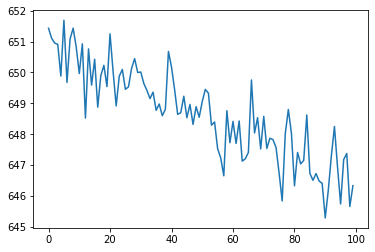

In [82]:
plt.plot(range(num_epochs), losses)

# Save weights

In [83]:
symae.save_weights('./checkpoint')